In [3]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm

In [4]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import european_call_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:
# ---------------------------------------------------------------------------
# 2) Optional: Model Hedge (e.g. Black-Scholes) function
# ---------------------------------------------------------------------------
def black_scholes_call_price_delta(S0, K, T, sigma):
    """
    For r=0. Returns (price, delta).
    """
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    price = S0*norm.cdf(d1) - K*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def compute_model_hedge_pnl(q, Z, delta_const, S_paths):
    """
    frictionless PnL = q - Z + delta_const * sum_{k=0}^{n-1} [S_{k+1}-S_k].
    """
    S_diff = S_paths[:,1:] - S_paths[:,:-1]  # shape (n_paths, n_steps)
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl

In [6]:
# ----------------------------------------------------------------------------
# 3) Simulation Setup
# ----------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365  # 30 days

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
print("Simulated S_paths shape:", S_paths_np.shape)

K = 100.0
Z_np = european_call_payoff(S_paths_np, K=K)  # <-- NO MORE NameError
print("Payoff shape:", Z_np.shape)

# Convert to torch
S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

Simulated S_paths shape: (200000, 31)
Payoff shape: (200000,)


In [7]:
# ----------------------------------------------------------------------------
# 4) Model Hedge
# ----------------------------------------------------------------------------
sigma_guess = 0.2
q_bs, delta_bs = black_scholes_call_price_delta(S0=100.0, K=K, T=T, sigma=sigma_guess)
model_pnl = compute_model_hedge_pnl(q_bs, Z_np, delta_bs, S_paths_np)
print("Model Hedge Stats:")
print("  mean PnL =", model_pnl.mean())
print("  std PnL  =", model_pnl.std())

Model Hedge Stats:
  mean PnL = 0.04533853082149925
  std PnL  = 1.7444771163482315


In [8]:
# ----------------------------------------------------------------------------
# 5) Train Recurrent Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
import torch

# Ensure tensors are on the correct device
S_torch = S_torch.to(device)
Z_torch = Z_torch.to(device)

# Define CVaR risk level
alpha = 0.5  

# Ensure num_steps is defined
num_steps = S_torch.shape[1] - 1  

# Initialize Recurrent Hedge Model (now using shared architecture)
recurrent_model = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

# Use the updated DeepHedgeCVaRTrainer
trainer_rec = DeepHedgeCVaRTrainer(
    model=recurrent_model, 
    loss_function="cvar", 
    alpha=alpha
)

# Train the model
p0_rec = trainer_rec.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,
    n_epochs=5,
    batch_size=4096
)

print(f"Recurrent Hedge Price p0_rec = {p0_rec:.4f}")

# Evaluate model performance (no gradient computation needed)
with torch.no_grad():
    deltas_rec = recurrent_model(S_torch)
    Sdiff = S_torch[:, 1:] - S_torch[:, :-1]  
    gains_rec = torch.sum(deltas_rec * Sdiff, dim=1)
    pnl_rec = (trainer_rec.p0 - Z_torch + gains_rec).cpu().numpy()


Epoch 1/5 | Loss: 1.3900 | p0: 2.2872
Epoch 2/5 | Loss: 1.2335 | p0: 2.2872
Epoch 3/5 | Loss: 1.3644 | p0: 2.2872
Epoch 4/5 | Loss: 1.2131 | p0: 2.2872
Epoch 5/5 | Loss: 1.2993 | p0: 2.2872
Recurrent Hedge Price p0_rec = 2.2872


In [9]:
# ----------------------------------------------------------------------------
# 6) Train Simpler Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
simple_model = SimpleHedgeModel(steps=num_steps, hidden_dim=16).to(device)
trainer_simp = DeepHedgeCVaRTrainer(simple_model, alpha=alpha)
p0_simp = trainer_simp.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,
    n_epochs=5,
    batch_size=4096
)
print(f"Simple Hedge Price p0_simp = {p0_simp:.4f}")

with torch.no_grad():
    deltas_simp = simple_model(S_torch)
    Sdiff_simp = S_torch[:,1:] - S_torch[:,:-1]
    gains_simp = torch.sum(deltas_simp * Sdiff_simp, dim=1)
    pnl_simp = (trainer_simp.p0 - Z_torch + gains_simp).cpu().numpy()

Epoch 1/5 | Loss: 5.6220 | p0: 2.2872
Epoch 2/5 | Loss: 1.2239 | p0: 2.2872
Epoch 3/5 | Loss: 1.1825 | p0: 2.2872
Epoch 4/5 | Loss: 1.2315 | p0: 2.2872
Epoch 5/5 | Loss: 1.2368 | p0: 2.2872
Simple Hedge Price p0_simp = 2.2872


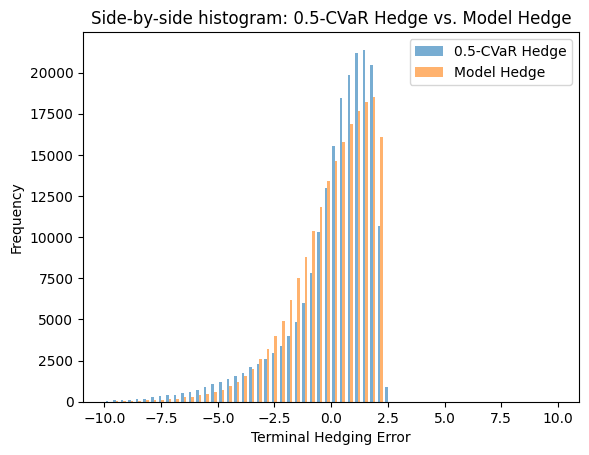

In [10]:
# ----------------------------------------------------------------------------
# 7) Figures
# ----------------------------------------------------------------------------

def plot_side_by_side_hist(pnl1, pnl2, label1="CVaR Hedge", label2="Model Hedge",
                           bins=50, range=(-10,10)):
    """
    Plot side-by-side histogram bars for two PnL arrays, over the same bins.
    
    Args:
      pnl1, pnl2: 1D arrays of data.
      label1, label2: legend labels for the two sets of bars.
      bins: int or sequence of bin edges
      range: (min, max) range for the histogram
    """
    # 1) Manually compute hist counts for each distribution
    counts1, edges = np.histogram(pnl1, bins=bins, range=range)
    counts2, _     = np.histogram(pnl2, bins=edges)  # use same edges for second data
    
    # 2) Convert counts to frequency or density, if desired (optional)
    # e.g. to show frequencies, we can keep as is, or for probability densities:
    # step = edges[1] - edges[0]
    # counts1 = counts1 / (counts1.sum() * step)
    # counts2 = counts2 / (counts2.sum() * step)
    
    # 3) The bin centers
    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0  # bar width is 1/3 of bin width
                                          # so the two bars can fit side by side
    
    # 4) Shift one bar group left, the other right
    plt.bar(
        centers - width/2, counts1, width=width,
        alpha=0.6, label=label1, color='tab:blue'
    )
    plt.bar(
        centers + width/2, counts2, width=width,
        alpha=0.6, label=label2, color='tab:orange'
    )
    
    # 5) Label and show
    plt.xlabel("Terminal Hedging Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Side-by-side histogram: {label1} vs. {label2}")
    plt.show()

plot_side_by_side_hist(pnl_rec, model_pnl,
                       label1="0.5-CVaR Hedge", label2="Model Hedge",
                       bins=60, range=(-10,10))


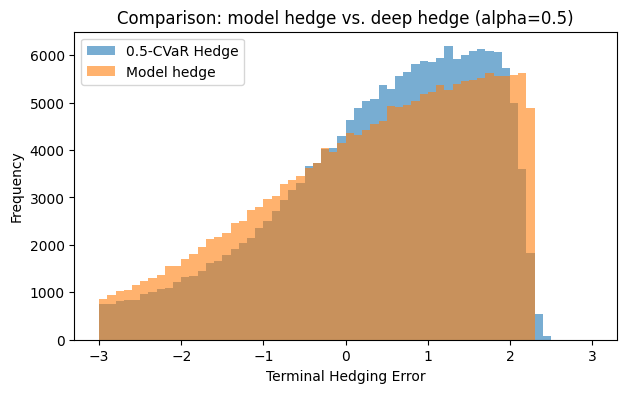

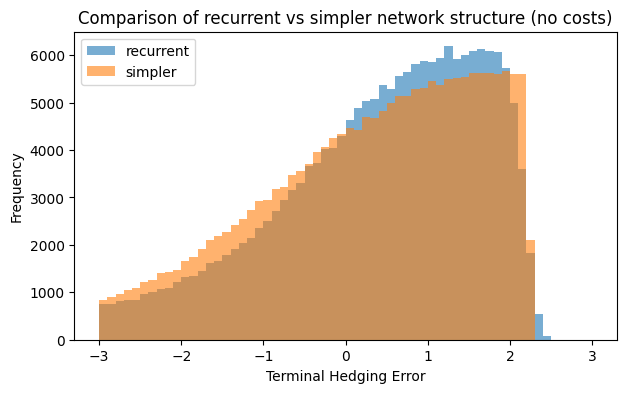

In [20]:
# ----------------------------------------------------------------------------
# 7) Figures (Updated for style)
# ----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Figure 2-style: Model Hedge vs. Deep Hedge
plt.figure(figsize=(7,4))
plt.hist(
    pnl_rec, bins=60, alpha=0.6, label='0.5-CVaR Hedge',
    color='tab:blue', range=(-3,3)  # adjust range as needed
)
plt.hist(
    model_pnl, bins=60, alpha=0.6, label='Model hedge',
    color='tab:orange', range=(-3,3)
)
plt.title('Comparison: model hedge vs. deep hedge (alpha=0.5)')
plt.xlabel('Terminal Hedging Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Figure 4-style: Recurrent vs. Simpler
plt.figure(figsize=(7,4))
plt.hist(
    pnl_rec, bins=60, alpha=0.6, label='recurrent',
    color='tab:blue', range=(-3,3)
)
plt.hist(
    pnl_simp, bins=60, alpha=0.6, label='simpler',
    color='tab:orange', range=(-3,3)
)
plt.title('Comparison of recurrent vs simpler network structure (no costs)')
plt.xlabel('Terminal Hedging Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


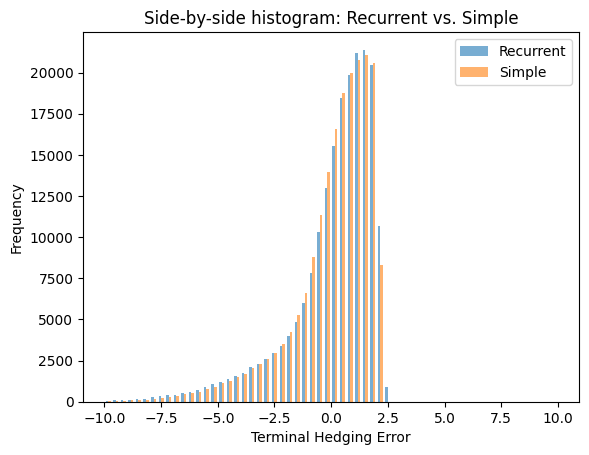

In [12]:
plot_side_by_side_hist(pnl_rec, pnl_simp,
                       label1="Recurrent", label2="Simple",
                       bins=60, range=(-10,10))

In [11]:
# ----------------------------------------------------------------------------
# 8) Numeric Table (Mean Loss, Price, Realized CVaR)
# ----------------------------------------------------------------------------
def empirical_cvar(x, alpha=0.99):
    x_sorted = np.sort(x)
    cutoff = int(len(x)*(1-alpha))
    if cutoff <= 0:
        return x_sorted[0]
    tail = x_sorted[:cutoff]
    return tail.mean()

alpha_cvar = 0.99

mean_rec = pnl_rec.mean()
real_cvar_rec = empirical_cvar(pnl_rec, alpha=alpha_cvar)

mean_simp = pnl_simp.mean()
real_cvar_simp = empirical_cvar(pnl_simp, alpha=alpha_cvar)

print("\n===== Architecture Comparison Table =====")
print("Architecture | Mean Loss |   Price   | Realized CVaR(99%)")
print("---------------------------------------------------------")
print(f"Recurrent    | {mean_rec:.4f}   | {p0_rec:.4f} | {real_cvar_rec:.4f}")
print(f"Simpler      | {mean_simp:.4f}   | {p0_simp:.4f} | {real_cvar_simp:.4f}")


===== Architecture Comparison Table =====
Architecture | Mean Loss |   Price   | Realized CVaR(99%)
---------------------------------------------------------
Recurrent    | 0.0465   | 2.2872 | -8.3841
Simpler      | 0.0462   | 2.2872 | -7.6305


In [13]:
# Define a higher risk aversion level (alpha = 0.99 for 99%-CVaR)
alpha_99 = 0.99  

# Initialize and train the model under 99%-CVaR
recurrent_model_99 = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)
trainer_rec_99 = DeepHedgeCVaRTrainer(model=recurrent_model_99, loss_function="cvar", alpha=alpha_99)

p0_rec_99 = trainer_rec_99.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,  
    n_epochs=5,
    batch_size=4096
)

print(f"99%-CVaR Hedge Price p0_rec_99 = {p0_rec_99:.4f}")

# Compute PnL for 99%-CVaR hedge
with torch.no_grad():
    deltas_rec_99 = recurrent_model_99(S_torch)
    Sdiff_99 = S_torch[:, 1:] - S_torch[:, :-1]
    gains_rec_99 = torch.sum(deltas_rec_99 * Sdiff_99, dim=1)
    pnl_rec_99 = (trainer_rec_99.p0 - Z_torch + gains_rec_99).cpu().numpy()


Epoch 1/5 | Loss: 82.6695 | p0: 2.2872
Epoch 2/5 | Loss: 82.0968 | p0: 2.2872
Epoch 3/5 | Loss: 78.0945 | p0: 2.2872
Epoch 4/5 | Loss: 148.2974 | p0: 2.2872
Epoch 5/5 | Loss: 261.1893 | p0: 2.2872
99%-CVaR Hedge Price p0_rec_99 = 2.2872


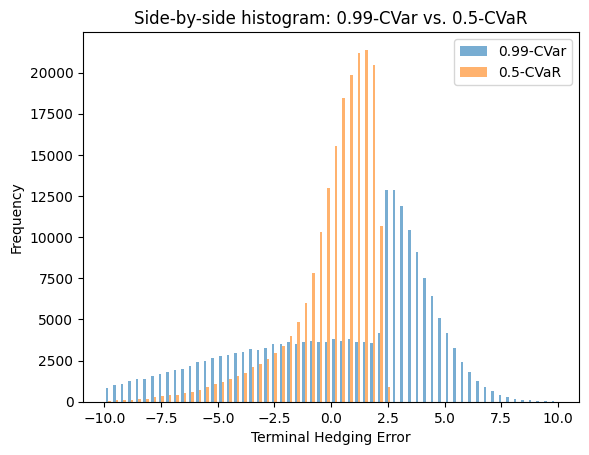

In [15]:
plot_side_by_side_hist(pnl_rec_99, pnl_rec,
                       label1="0.99-CVar", label2="0.5-CVaR",
                       bins=60, range=(-10,10))

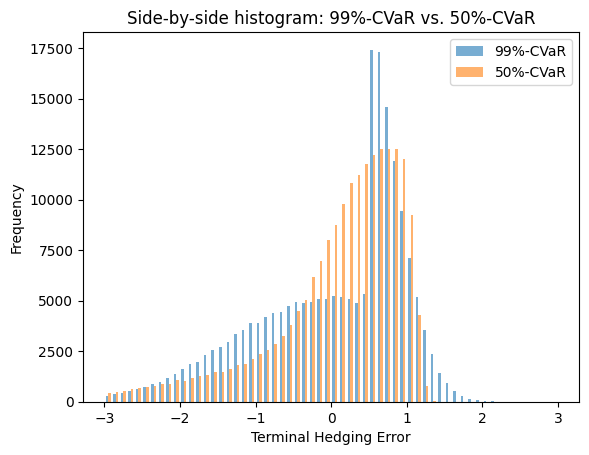

In [17]:
pnl_rec_99_scaled = pnl_rec_99 / np.std(pnl_rec_99)
pnl_rec_scaled = pnl_rec / np.std(pnl_rec)
plot_side_by_side_hist(pnl_rec_99_scaled, pnl_rec_scaled, label1="99%-CVaR", label2="50%-CVaR", bins=60, range=(-3,3))

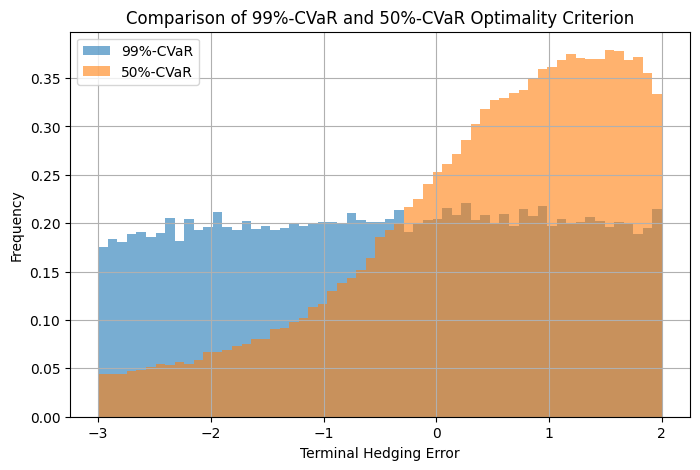

In [14]:
# Figure 7: Histogram of 99%-CVaR vs. 50%-CVaR Hedge
plt.figure(figsize=(8, 5))

bins = np.linspace(-3, 2, 60)
plt.hist(pnl_rec_99, bins=bins, alpha=0.6, label="99%-CVaR", color='tab:blue', density=True)
plt.hist(pnl_rec, bins=bins, alpha=0.6, label="50%-CVaR", color='tab:orange', density=True)

plt.xlabel("Terminal Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Comparison of 99%-CVaR and 50%-CVaR Optimality Criterion")
plt.grid(True)
plt.show()

In [18]:
def compute_cvar(pnl, alpha):
    """
    Computes empirical CVaR at the given alpha level.
    """
    quantile = np.percentile(pnl, 100 * (1 - alpha))
    cvar = pnl[pnl <= quantile].mean()
    return cvar

# Compute Mean Loss
mean_loss_99 = pnl_rec_99.mean()
mean_loss_50 = pnl_rec.mean()

# Compute Realized CVaR
cvar_50_50 = compute_cvar(pnl_rec, alpha=0.50)
cvar_50_99 = compute_cvar(pnl_rec, alpha=0.99)

cvar_99_50 = compute_cvar(pnl_rec_99, alpha=0.50)
cvar_99_99 = compute_cvar(pnl_rec_99, alpha=0.99)

# Display Results
import pandas as pd
table_data = {
    "Mean Loss": [mean_loss_99, mean_loss_50],
    "Realized 50%-CVaR": [cvar_99_50, cvar_50_50],
    "Realized 99%-CVaR": [cvar_99_99, cvar_50_99]
}

df = pd.DataFrame(table_data, index=["99%-CVaR", "50%-CVaR"])
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Comparison of 99%-CVaR and 50%-CVaR", dataframe=df)

In [19]:
df

,Mean Loss,Realized 50%-CVaR,Realized 99%-CVaR
99%-CVaR,0.039924,-3.635768,-14.764694
50%-CVaR,0.046485,-1.299308,-8.384121


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from scipy.stats import norm

# Extract stock price paths and volatility from simulation
S_numpy = S_torch.cpu().detach().numpy()  # Convert to NumPy
V_numpy = V_paths_np  # Volatility from Heston model

# Get unique s_t and v_t for meshgrid
s_t_unique = np.unique(S_numpy[:, -1])  # Last step stock prices
v_t_unique = np.unique(V_numpy[:, -1])  # Last step volatilities
S, V = np.meshgrid(s_t_unique, v_t_unique)

# Compute Network Delta (Deep Hedge)
deltas_rec_numpy = deltas_rec.cpu().detach().numpy()
deltas_rec_grid = deltas_rec_numpy.reshape(S.shape)  # Ensure shape fits

# Compute Model Delta (Black-Scholes)
def black_scholes_delta(S, K, T, sigma):
    d1 = (np.log(S/K) + 0.5*sigma**2*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

model_delta_grid = black_scholes_delta(S, K=100, T=30/365, sigma=0.2)  # Use assumed sigma

# Compute Difference
difference_grid = deltas_rec_grid - model_delta_grid

# Plotting
fig = plt.figure(figsize=(12, 8))

# Network Delta (Deep Hedge)
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(S, V, deltas_rec_grid, cmap='coolwarm')
ax1.set_title("Network Delta")

# Model Delta (Black-Scholes)
ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_surface(S, V, model_delta_grid, cmap='coolwarm')
ax2.set_title("Model Delta")

# Difference
ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_surface(S, V, difference_grid, cmap='coolwarm')
ax3.set_title("Difference (Network - Model)")

# Labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$s_t$ (Stock Price)")
    ax.set_ylabel("$v_t$ (Volatility)")
    ax.set_zlabel("Delta")

plt.tight_layout()
plt.show()

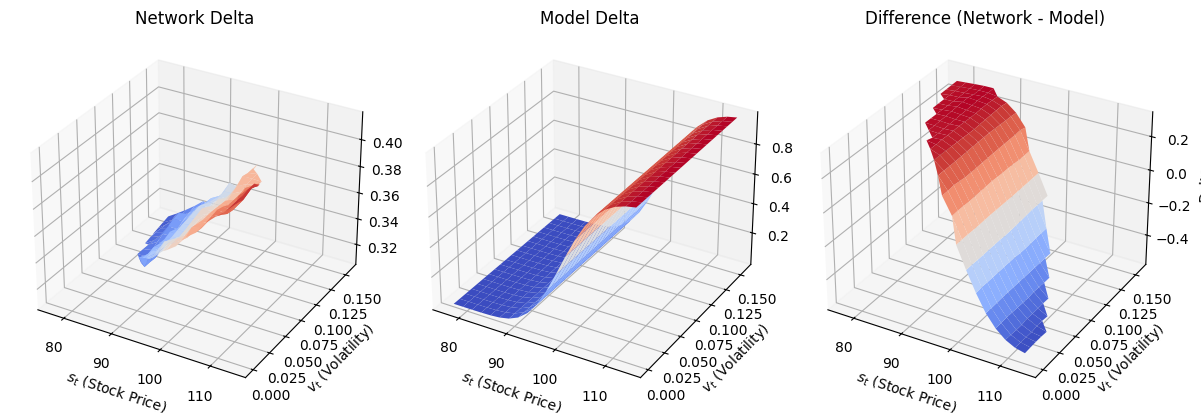

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from scipy.stats import norm

# Sample data to reduce memory usage
sample_size = 500  # Adjust based on available memory
indices = np.random.choice(S_torch.shape[0], sample_size, replace=False)

# Extract a subset of stock prices and volatilities
S_sampled = S_torch[indices, -1].cpu().detach().numpy()  # Last step stock price
V_sampled = V_paths_np[indices, -1]  # Last step volatility

# Create a small meshgrid (reducing resolution)
s_t_unique = np.linspace(S_sampled.min(), S_sampled.max(), 20)
v_t_unique = np.linspace(V_sampled.min(), V_sampled.max(), 20)
S, V = np.meshgrid(s_t_unique, v_t_unique)

# Compute Network Delta (Deep Hedge) using sampled points
deltas_rec_sampled = deltas_rec[indices, -1].cpu().detach().numpy()

# Interpolate onto a grid for smoother plotting
from scipy.interpolate import griddata
deltas_rec_grid = griddata((S_sampled, V_sampled), deltas_rec_sampled, (S, V), method='linear')

# Compute Model Delta (Black-Scholes)
def black_scholes_delta(S, K, T, sigma):
    d1 = (np.log(S/K) + 0.5*sigma**2*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

model_delta_grid = black_scholes_delta(S, K=100, T=30/365, sigma=0.2)

# Compute Difference
difference_grid = deltas_rec_grid - model_delta_grid

# Plotting
fig = plt.figure(figsize=(12, 8))

# Network Delta (Deep Hedge)
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(S, V, deltas_rec_grid, cmap='coolwarm')
ax1.set_title("Network Delta")

# Model Delta (Black-Scholes)
ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_surface(S, V, model_delta_grid, cmap='coolwarm')
ax2.set_title("Model Delta")

# Difference
ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_surface(S, V, difference_grid, cmap='coolwarm')
ax3.set_title("Difference (Network - Model)")

# Labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$s_t$ (Stock Price)")
    ax.set_ylabel("$v_t$ (Volatility)")
    ax.set_zlabel("Delta")

plt.tight_layout()
plt.show()